In [1]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 

# Closure Simulations

The purpose of this simulation is to see if a lack of redundancy in the telescope can cause a similar effect to what I see in the HERA data.

We will start by generating some electric fields at locations that correspond to a HERA-like layout. We will use a gaussian beam first, then switch to using a different beam for each telescope and see what happens.

Then we will look at different sky layouts and how that shakes things up.

In [2]:
# For simulating Electric Fields
def simulate_electric_fields(locations_uvw,points):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    
    for i in numpy.arange(locations_uvw.shape[0]):
        for point in points:
            l = point[0]
            m = point[1]
            n = numpy.sqrt(1.0-l**2-m**2) - 1.0
            amp = point[2]
            u = locations_uvw[i,0]
            v = locations_uvw[i,1]
            w = locations_uvw[i,2]
            elec_ss[i] += amp*numpy.exp(-2j*numpy.pi*(u*l+v*m+w*n))
    return elec_ss

# 7 Antennas
def generate_hera_layout_simple():
    layout_vec = numpy.zeros(shape=(14,3))
    
    
    layout_vec[0] = numpy.asarray([-7,24.2486,0])
    layout_vec[1] = numpy.asarray([7,24.2486,0])
    layout_vec[2] = numpy.asarray([-14,12.1243,0])
    layout_vec[3] = numpy.asarray([0,12.1243,0])
    layout_vec[4] = numpy.asarray([14,12.1243,0])
    layout_vec[5] = numpy.asarray([-21,0,0])
    layout_vec[6] = numpy.asarray([-7,0,0])
    layout_vec[7] = numpy.asarray([7,0,0])
    layout_vec[8] = numpy.asarray([21,0,0])
    layout_vec[9] = numpy.asarray([-14,-12.1243,0])
    layout_vec[10] = numpy.asarray([0,-12.1243,0])
    layout_vec[11] = numpy.asarray([14,-12.1243,0])
    layout_vec[12] = numpy.asarray([-7,-24.2486,0])
    layout_vec[13] = numpy.asarray([7,-24.2486,0])

    
    
    return layout_vec

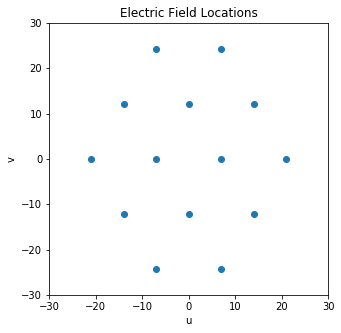

In [3]:
locs = generate_hera_layout_simple()
us = locs[:,0]
vs = locs[:,1]
ws = locs[:,2]
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(us,vs)
ax.set_title('Electric Field Locations')
ax.set_xlim([-30,30])
ax.set_ylim([-30,30])
ax.set_xlabel('u'); ax.set_ylabel('v');# ax.set_zlabel('v'); 

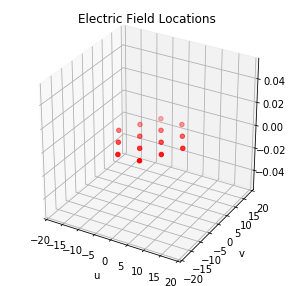

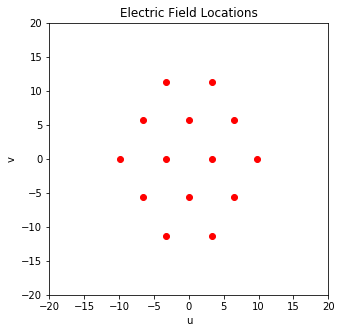

In [1362]:
frequency = 140e6 # Let's just do this in a single channel for now.
chan_bw = 25e3

wavelength = 3e8 / frequency

locs_uvw = locs/wavelength

us_uvw = locs_uvw[:,0]
vs_uvw = locs_uvw[:,1]
ws_uvw = locs_uvw[:,2]

fig, ax = plt.subplots(figsize=(5,5),subplot_kw={'projection': '3d'})
ax.scatter(us_uvw,vs_uvw,ws_uvw,color='red')
ax.set_title('Electric Field Locations')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_xlabel('u'); ax.set_ylabel('v');
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(us_uvw,vs_uvw,color='red')
ax.set_title('Electric Field Locations')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_xlabel('u'); ax.set_ylabel('v');
plt.show()

Now let's try and generate some sort of beam to work with.

(2000,)


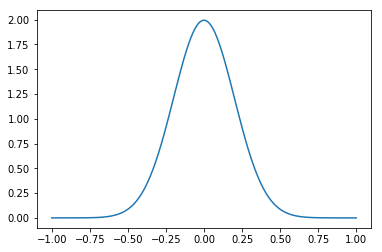

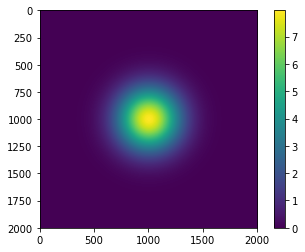

In [1363]:
from scipy.stats import norm

def generate_gaussian_beam():

    x = numpy.linspace(-1,1,2000)
    return x,norm.pdf(x, loc=0, scale=0.2)+ 1j*norm.pdf(x, loc=0,scale=0.2)#*norm.cdf(2*x,loc=0,scale=0.2) + 1j*norm.pdf(x, loc=0,scale=0.2)#*norm.cdf(2*x,loc=0,scale=0.2)

def find_beam_at_point(beam,point):
    beam_shape = beam.shape[0]
    
    pl = point[0]
    pm = point[1]
    
    step = 2/beam_shape
    
    bl_ind = int((pl + 1)/step)
    bm_ind = int((pm + 1)/step)
    
    return beam[bl_ind] * beam[bm_ind]

    
angle, beam = generate_gaussian_beam()
print(angle.shape)
plt.plot(angle, beam)
plt.show()

# 2D one too

beam_2D = numpy.outer(beam,beam.T.conj())
plt.imshow(beam_2D.real)
plt.colorbar()
plt.show()

In [1438]:
# For simulating Electric Fields
def simulate_electric_fields_gaussianbeam(locations_uvw,points,beam):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    phase_source = numpy.zeros(shape=(points.shape[0]),dtype=numpy.complex128)
    print(phase_source.shape)
    for i in numpy.arange(points.shape[0]):
        phase_source[i] = numpy.exp(-2j*numpy.pi * numpy.random.uniform(0,1))
    
    for i in numpy.arange(locations_uvw.shape[0]):
        #print(locations_uvw[i,:])
        #numpy.random.seed(12345)
        antenna_noise = 500*(numpy.random.normal(scale=4000.0) + 1j * numpy.random.normal(scale=4000.0))
        #antenna_phase_noise = numpy.exp(1j*numpy.random.uniform(-0.1,0.1))
        #antenna_noise = 0
        
        for j,point in enumerate(points):
            #print(j)
            l = point[0]
            m = point[1]
            n = numpy.sqrt(1.0-l**2-m**2) - 1.0
            u = locations_uvw[i,0]
            v = locations_uvw[i,1]
            w = locations_uvw[i,2]
            elec_ss[i] += point[2]*numpy.exp(-2j*numpy.pi*(u*l+v*m+w*n))  * find_beam_at_point(beam,point) * phase_source[j] #* numpy.random.uniform(0.9,1.1)
        #elec_ss[i] += antenna_noise #* antenna_phase_noise
    return elec_ss

In [1439]:
#points = [[0.2,0.2,80],[0.05,0.3,40],[-0.45,0.45,790],[0.45,0.45,100],[0.45,-0.45,100],
#          [-0.45,-0.45,100],[0.5,0.0,100],[0.0,0.5,80],[-0.5,0.0,100],[-0.5,-0.5,100],
#          [-0.8,0.0,100],[0.8,0.0,100],[0.21,0.21,80],[0.205,0.205,100]]
points = [[0.0,0.0,100],[0.01,-0.05,80]]
#points = [[0.0,0.0,1],[0.48,0.49,4],[0.47,0.49,4],[0.48,0.48,4]]
efields = simulate_electric_fields_gaussianbeam(locs_uvw,numpy.asarray(points),beam)

(2,)


In [1440]:
print(efields)
print(numpy.abs(efields))
print(locs_uvw)

[ 574.40796835 -127.34241721j  788.28436773 -258.72275116j
  944.86355654 -916.16171942j  813.16935717-1129.84499956j
  607.14179584-1273.22055652j  155.50121255-1285.45878716j
  -57.98848777-1153.45100625j -201.06140662 -947.21316722j
 -249.94478499 -701.01340751j  -80.31546082 -282.25944257j
  126.13221137 -139.48947021j  372.40347486  -90.96760774j
  933.37466184 -467.86861162j  981.53490383 -714.21084806j]
[ 588.35414958  829.65637849 1316.10008609 1392.04674005 1410.57142527
 1294.83007402 1154.90774027  968.31734126  744.23933856  293.4637391
  188.06022186  383.35291018 1044.07341557 1213.88133807]
[[ -3.26666667  11.31601333   0.        ]
 [  3.26666667  11.31601333   0.        ]
 [ -6.53333333   5.65800667   0.        ]
 [  0.           5.65800667   0.        ]
 [  6.53333333   5.65800667   0.        ]
 [ -9.8          0.           0.        ]
 [ -3.26666667   0.           0.        ]
 [  3.26666667   0.           0.        ]
 [  9.8          0.           0.        ]
 [ -6.533

DFT Sky to see what it looks like

In [1441]:
def epic_image_dft(theta,lam,efield,locations):
    grid_size = int(theta*lam)
    image = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)
    
    for lg in numpy.arange(grid_size):
        
        lv = (1.0 / (0.5*grid_size)) * (lg - grid_size/2)
        print(lv)
        for mg in numpy.arange(grid_size):
            mv = (1.0/ (0.5*grid_size)) * (mg - grid_size/2)
            if (lv**2 + mv**2 > 1.0):
                continue
                
            else:
                nv = 1.0 - numpy.sqrt(1.0 - lv**2 - mv**2)
            #print(nv)
            for j,efieldd in enumerate(efield):
                u = locations[j,0]
                v = locations[j,1]
                w = locations[j,2]
                #w = 0
                image[lg,mg] += efieldd * numpy.exp(2j*numpy.pi*(u*lv + v*mv + w*nv))
    return image / (grid_size**2)

In [1442]:
image = epic_image_dft(2,32,efields,locs_uvw)

-1.0
-0.96875
-0.9375
-0.90625
-0.875
-0.84375
-0.8125
-0.78125
-0.75
-0.71875
-0.6875
-0.65625
-0.625
-0.59375
-0.5625
-0.53125
-0.5
-0.46875
-0.4375
-0.40625
-0.375
-0.34375
-0.3125
-0.28125
-0.25
-0.21875
-0.1875
-0.15625
-0.125
-0.09375
-0.0625
-0.03125
0.0
0.03125
0.0625
0.09375
0.125
0.15625
0.1875
0.21875
0.25
0.28125
0.3125
0.34375
0.375
0.40625
0.4375
0.46875
0.5
0.53125
0.5625
0.59375
0.625
0.65625
0.6875
0.71875
0.75
0.78125
0.8125
0.84375
0.875
0.90625
0.9375
0.96875


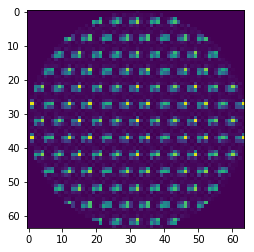

In [1443]:
plt.imshow((image * image.conj()).real)
plt.show()

Dreadful but expected considering HERA's PSF is rubbish.

## Visibilities

Let's start making some visibilities up

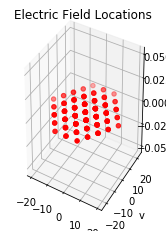

In [1444]:
visibilities = numpy.outer(efields,efields.T.conj())

def generate_baseline_vectors(locations):
    
    loc_no = locations.shape[0]
    baseline_vectors = numpy.zeros(shape=(loc_no, loc_no,3))
    
    for i in numpy.arange(loc_no):
        for j in numpy.arange(loc_no):
            baseline_vectors[i,j,0] = (locations[i,0] - locations[j,0])#/2
            baseline_vectors[i,j,1] = (locations[i,1] - locations[j,1])#/2
            baseline_vectors[i,j,2] = (locations[i,2] - locations[j,2])#/2
            
    return baseline_vectors


def plot_baselines(baselines):
    
    us = baselines[:,:,0]
    vs = baselines[:,:,1]
    ws = baselines[:,:,2]
    ax = plt.subplot(121, projection='3d')
    ax.scatter(us,vs,ws, color='red')
    ax.set_title('Electric Field Locations')
    ax.set_xlabel('u'); ax.set_ylabel('v'); ax.set_zlabel('w')
    plt.show()
    

baselines = generate_baseline_vectors(locs_uvw)
plot_baselines(baselines)

In [1445]:
baselines_ew_14m = numpy.asarray([[0,1],[2,3],[3,4],[5,6]])
visibilities_ew_14m = visibilities[baselines_ew_14m[:,0],baselines_ew_14m[:,1]]

## Closure Phases

Closure phases can be generated by multipling three visibilities from a set of baselines comprising three antennas in a closed geometric triangle.

The phase of the resulting complex number is taken and provides our closure phase for each 'triad'

Should do as Bojan does and just give each antenna an id, in this case comensurate with its position in the array and extract the baselines I care about. 



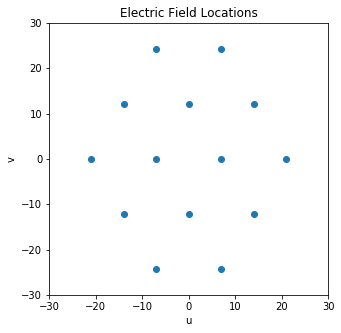

In [1446]:
us = locs[:,0]
vs = locs[:,1]
ws = locs[:,2]
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(us,vs)
ax.set_title('Electric Field Locations')
ax.set_xlim([-30,30])
ax.set_ylim([-30,30])
ax.set_xlabel('u'); ax.set_ylabel('v');# ax.set_zlabel('v'); 

In [1447]:
List_of_antennas = [[[0,2],[2,3],[3,0]],
                    [[1,3],[3,4],[4,1]],
                    [[2,5],[5,6],[6,2]],
                    [[3,6],[6,7],[7,3]],
                    [[6,9],[9,10],[10,6]],
                    [[7,10],[10,11],[11,7]],
                    [[10,12],[12,13],[13,10]],
                    [[0,13],[13,5],[5,0]]]

In [1448]:
def generate_closure_triads(visb,antenna_list):
    
    ant_list = numpy.asarray(antenna_list)
    triads = numpy.zeros(shape=ant_list.shape[0])
    for i,triadconfig in enumerate(ant_list):
        vis1l = triadconfig[0]
        vis2l = triadconfig[1]
        vis3l = triadconfig[2]
        #print(triadconfig)
        vis1 = numpy.angle(visb[vis1l[0],vis1l[1]])
        vis2 = numpy.angle(visb[vis2l[0],vis2l[1]])
        vis3 = numpy.angle(visb[vis3l[0],vis3l[1]])
        print(vis1,vis2,vis3)
        triads[i] = vis1 + vis2 + vis3
        
    return triads

def generate_closure_triads_tp(visb,antenna_list):
    
    ant_list = numpy.asarray(antenna_list)
    triads = numpy.zeros(shape=ant_list.shape[0])
    for i,triadconfig in enumerate(ant_list):
        vis1l = triadconfig[0]
        vis2l = triadconfig[1]
        vis3l = triadconfig[2]
        #print(triadconfig)
        triple_product = numpy.angle(visb[vis1l[0],vis1l[1]] * visb[vis2l[0],vis2l[1]] * visb[vis3l[0],vis3l[1]])
        vis1 = numpy.arctan2(numpy.sin(triple_product),numpy.cos(triple_product))
        #vis2 = numpy.angle(visb[vis2l[0],vis2l[1]])
        #vis3 = numpy.angle(visb[vis3l[0],vis3l[1]])
        #print(vis1,vis2,vis3)
        triads[i] = vis1# + vis2 + vis3
        
    return triads

In [1449]:
closures = generate_closure_triads(visibilities,List_of_antennas)
closures1 = generate_closure_triads_tp(visibilities,List_of_antennas)

0.5518119026014188 0.17698247689523677 -0.7287943794966556
0.6298268498197416 0.17887616365500647 -0.808703013474748
0.680435053432515 0.17061609646802942 -0.8510511499005444
0.6740686730053076 0.15893013623718893 -0.8329988092424966
0.22698650120396852 -1.0123718241512587 0.7853853229472904
-0.9443154591844792 -0.5960625772101192 1.5403780363945985
-0.37098304119588826 0.1643814062301383 0.20660163496574996
0.41087609458892305 0.8213708614450108 -1.2322469560339337


In [1450]:
print(closures)
print(closures1)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[-1.10165817e-16  0.00000000e+00  0.00000000e+00 -1.05633660e-16
  0.00000000e+00 -6.41243809e-18  0.00000000e+00 -3.74191839e-17]


Zero closures? Seems suspicious. Let's try screwing up the beam shapes and see what happens.
Let's make a different gaussian beam for each antenna and see what happens.

In [1451]:
def generate_beam_per_antenna(locs):
    beams_matrix = numpy.zeros(shape=(locs.shape[0],2000),dtype=numpy.complex128)
    
    x = numpy.linspace(-1,1,2000)
    
    for i in numpy.arange(locs.shape[0]):
        a1 = numpy.random.uniform(-2.0,2.0)
        a2 = numpy.random.uniform(-2.0,2.0)
        beamr = norm.pdf(x, loc=0, scale=numpy.random.uniform(0.4,0.5))*norm.cdf(a1*x)
        beamp = norm.pdf(x, loc=0, scale=numpy.random.uniform(0.4,0.5))*norm.cdf(a2*x)
        #beams_matrix[i,:] = beamr * numpy.exp(1j * beamp)
        beams_matrix[i,:] = beamr + 1j * beamp
        plt.plot(x, beams_matrix[i,:].real)
        plt.show()
        plt.plot(x, beams_matrix[i,:].imag)
        plt.show()
    
    return x,beams_matrix

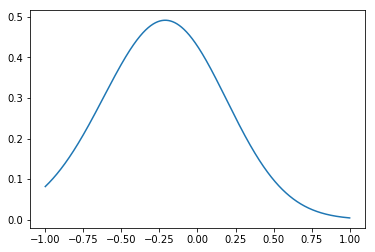

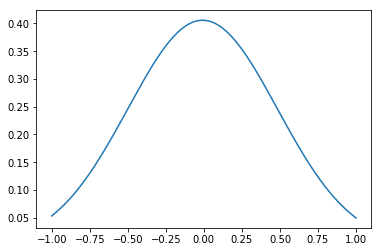

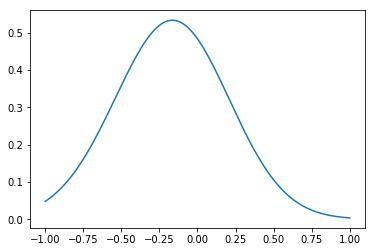

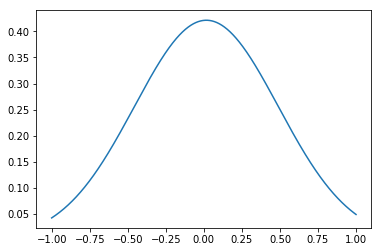

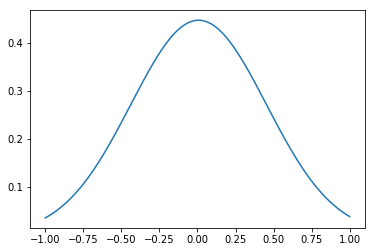

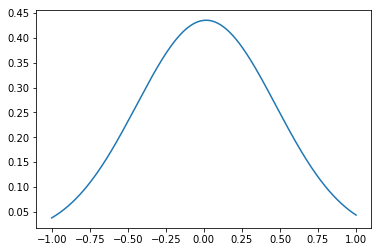

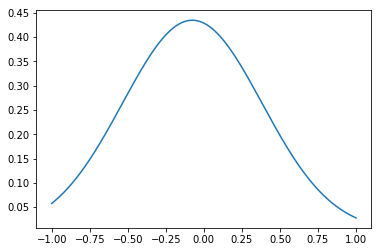

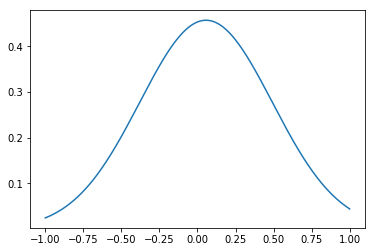

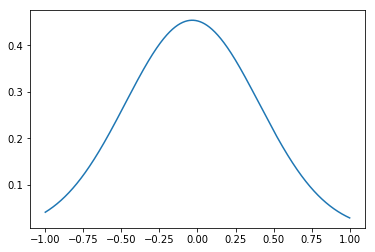

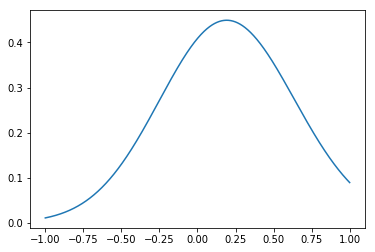

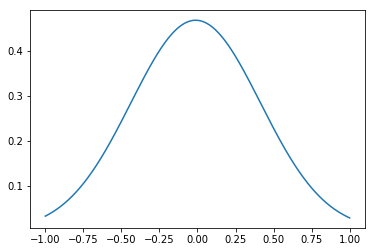

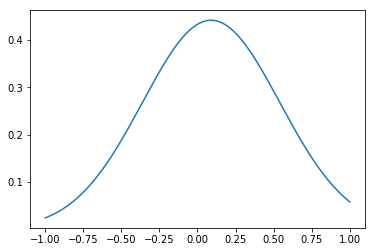

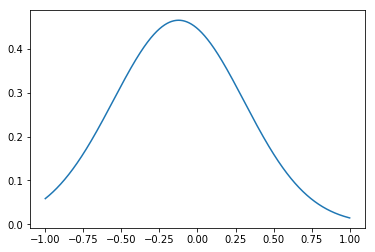

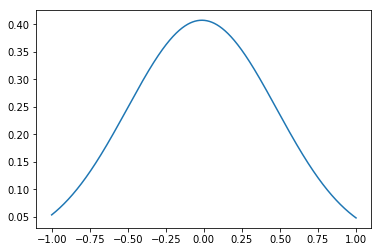

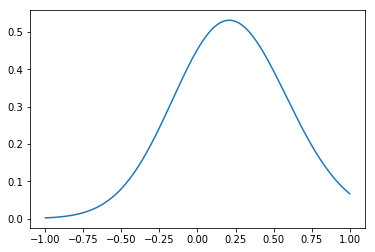

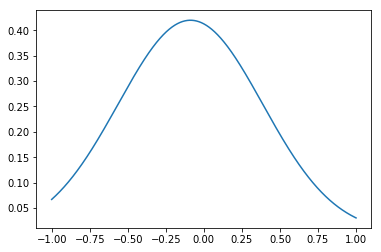

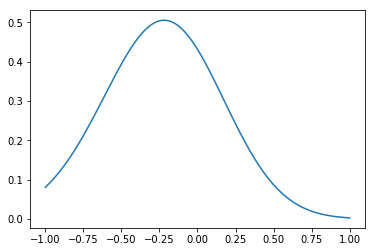

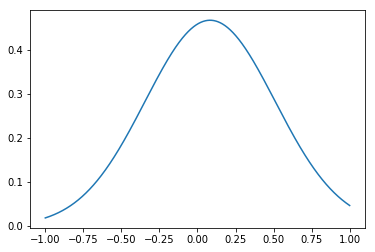

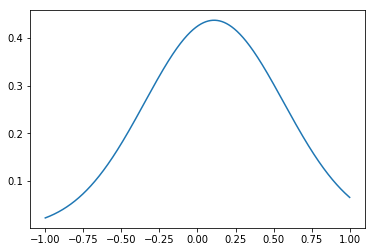

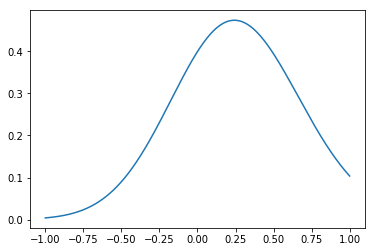

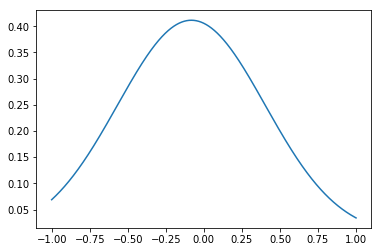

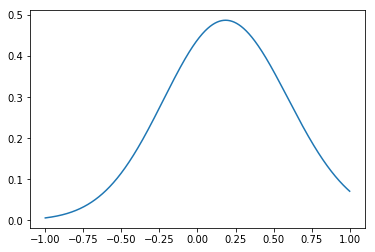

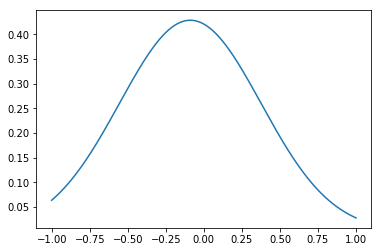

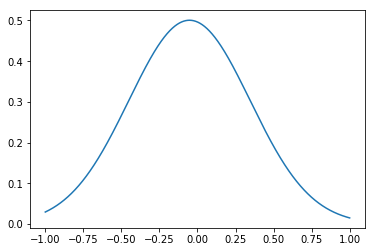

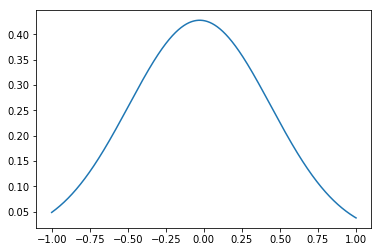

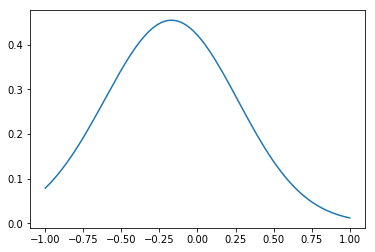

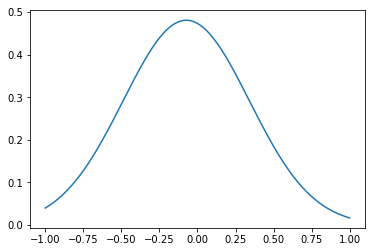

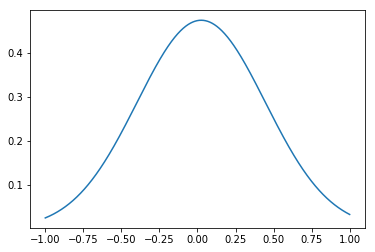

In [1478]:
x,beams = generate_beam_per_antenna(locs)

In [1479]:
print(beams[2])

[0.03483559+0.03731969j 0.03501257+0.03750085j 0.03519028+0.0376827j  ...
 0.03793422+0.04346396j 0.0377455 +0.0432604j  0.03755753+0.04305759j]


In [1480]:
# For simulating Electric Fields
def simulate_electric_fields_different_beams(locations_uvw,points,beam_matrices):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    
    phase_source = numpy.zeros(shape=(points.shape[0]),dtype=numpy.complex128)
    print(phase_source.shape)
    for i in numpy.arange(points.shape[0]):
        phase_source[i] = numpy.exp(-1j*numpy.random.uniform(0,2*numpy.pi))
    
    for i in numpy.arange(locations_uvw.shape[0]):
        
        antenna_noise = numpy.random.normal(scale=4000.0)# + 1j * numpy.random.normal(scale=2000.0)
        for j,point in enumerate(points):
            l = point[0]
            m = point[1]
            n = numpy.sqrt(1.0-l**2-m**2) - 1.0
            bap = find_beam_at_point(beam_matrices[i,:],point)
            #print(bap)
            amp = point[2]
            #print(amp)
            u = locations_uvw[i,0]
            v = locations_uvw[i,1]
            w = locations_uvw[i,2]
            elec_ss[i] += amp*numpy.exp(-2j*numpy.pi*(u*l+v*m+w*n)) * bap * phase_source[j]
        #elec_ss[i] += antenna_noise
    return elec_ss

In [1481]:
#beams[7,:] = 0.0

efields_db = simulate_electric_fields_different_beams(locs_uvw,numpy.asarray(points),beams)
print(efields_db)


(2,)
[ 5.34275636 +9.66529918j 11.90996321+23.6741516j
 37.67235916+41.10445623j 47.01856307+42.48768112j
 59.82690754+24.67887948j 71.80023124 +6.68318813j
 61.75727273 -6.62548933j 56.10310811-14.47592293j
 49.22981303-15.98400069j 21.39252975-15.457294j
 14.30331994 -7.44503143j  8.45272379 +1.5819607j
 14.2012746 +30.78556972j 30.63181599+46.37110476j]


In [1482]:
visibilities_db = numpy.outer(efields_db,efields_db.T.conj()) 

# Show how adding a correlated noise breaks the closure relationship.
#visibilities_db = visibilities_db + 50000*(numpy.random.randn(visibilities_db.shape[0],visibilities_db.shape[1]) + 1j*numpy.random.randn(visibilities_db.shape[0],visibilities_db.shape[1]))

In [1483]:
closures_db = generate_closure_triads(visibilities_db,List_of_antennas)
closures_db1 = generate_closure_triads_tp(visibilities_db,List_of_antennas)

0.23688548238454632 0.09411749185550958 -0.33100297424005587
0.36986824393858214 0.34358090697975574 -0.7134491509183378
0.7361250899566907 0.1996868535258604 -0.935811943482551
0.8416944516270415 0.14564189975119773 -0.9873363513782393
0.5188301937345801 -0.1457829312570788 -0.3730472624775013
0.22740536272630352 -0.664934864681325 0.4375295019550215
-1.61850929266872 0.1515685247846117 1.4669407678841082
0.07880392046049034 0.8942066518807466 -0.973010572341237


In [1484]:
print(closures_db)
print(closures_db1)

[ 0.00000000e+00  0.00000000e+00  1.11022302e-16 -1.11022302e-16
 -5.55111512e-17  0.00000000e+00  0.00000000e+00 -1.11022302e-16]
[ 3.91447294e-17  0.00000000e+00  1.22336279e-16 -7.33432297e-17
 -1.27957467e-16  1.15420703e-16 -3.22858922e-17 -6.08588465e-17]


# This makes sense as I have only added direction-independent noise apart from each sources own phase. 

We can break closure by including correlated baseline terms, especially correlated baseline noise, which casuses closures to diverge. 

But the beam shapes require a more complicated sky model to explore.

## Let's try doing some continuum modelling

In [1485]:
# Generate a sky model
# We assume this sky is an entire celestial hemisphere.
# Points are [[l1,m1,amp1],[l2,m2,amp2]]
# Continuum is in the form of [[l,m,support,scale,amp],...] The amp has some random fluctuation imposed on it
def generate_continuum_model(grid_size,points,continuum):
    
    # Each axis runs from -1 to 1, l/m respectively.
    sky = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)
    
    lm_step = 2/grid_size
    
    # First generate points
    for j,point in enumerate(points):
        
        l = point[0]
        m = point[1]
        if(l**2 + m**2 > 1):
            continue
        lc = int(numpy.floor(l/lm_step) - grid_size/2)
        mc = int(numpy.floor(m/lm_step) - grid_size/2)
        
        point_phase = numpy.random.uniform(0,2*numpy.pi)
        sky[mc,lc] += point[2] * numpy.exp(1j*point_phase)
        
    # Now place down continuum emission
    for j,contin in enumerate(continuum):
    
        l = contin[0]
        m = contin[1]
        support=contin[2]
        scale = contin[3]
        amp = contin[4]
        x = numpy.linspace(-support//2,support//2,support)
        gaussian = amp * (norm.pdf(x, loc=0, scale=scale)) * norm.cdf(4*x,loc=0,scale=scale)
        gaussian2d = numpy.outer(gaussian,gaussian.T)
        
        lc = int(numpy.floor(l/lm_step) - grid_size/2)
        mc = int(numpy.floor(m/lm_step) - grid_size/2)
        for cm in numpy.arange(-support//2,support//2):           
            for cl in numpy.arange(-support//2,support//2):            
                sky[mc+cm,lc+cl] += gaussian2d[int(cm+support//2),int(cl+support//2)] * numpy.exp(-1j*numpy.random.uniform(0,numpy.pi/8))
                
    return sky
                
    
    

In [1486]:
continuums = [[-0.01,-0.02,64,16,1000],[0.01,0.02,64,16,1000],[-0.4,-0.4,64,70,1000],[-0.5,0.2,16,9.5,1000],[-0.3,-0.1,64,7.2,1000]]

In [1487]:
skycont = generate_continuum_model(512,points,continuums)

<function matplotlib.pyplot.show(*args, **kw)>

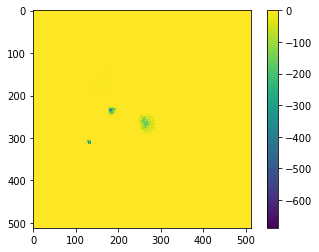

In [1488]:
plt.imshow(numpy.imag(skycont))
plt.colorbar()
plt.show

In [1489]:
print(numpy.abs(visibilities))

[[ 346160.60532813  488131.77301198  774332.94691271  819016.47591749
   829915.5513389   761818.64705071  679494.76137134  569713.52584058
   437876.30312067  172660.6086523   110646.01190134  225547.2754602
   614284.92651884  714192.12235162]
 [ 488131.77301198  688329.70637417 1091910.83115827 1154920.45704237
  1170289.58029831 1074264.02997519  958176.57328781  803370.6585816
   617462.91435911  243474.06300287  156025.36260562  318051.18714779
   866222.16884541 1007104.39486383]
 [ 774332.94691271 1091910.83115827 1732119.43660126 1832072.83441768
  1856453.17423619 1704125.97188709 1519974.17639613 1274402.53619267
   979493.45754485  386227.65229666  247506.07417758  504530.79809494
  1374105.11211841 1597589.33353537]
 [ 819016.47591749 1154920.45704237 1832072.83441768 1937794.12648201
  1963581.35415898 1802463.98345721 1607685.55490368 1347942.99823394
  1036015.94505453  408515.24134044  261788.61877092  533645.16890967
  1453398.99452103 1689779.55946775]
 [ 829915.5513

I mean it's not exactly something Carl Sagan would drool over but I think it should suffice to prove the mathematics here

In [1490]:
# For simulating Electric Fields
def simulate_electric_fields_fromsky_gaussianbeam(locations_uvw,sky,beam):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    grid_size = sky.shape[0]
    lm_step = 2/grid_size
    for i in numpy.arange(locations_uvw.shape[0]):
        #print(locations_uvw[i,:])
        #numpy.random.seed(12345)
        antenna_noise = 5000*(numpy.random.normal(scale=4000.0) + 1j * numpy.random.normal(scale=4000.0))
        #antenna_noise = 0
        
        for lc in numpy.arange(grid_size):
            l = (lc-grid_size//2) * lm_step
            for mc in numpy.arange(grid_size):
                m = (mc-grid_size//2) * lm_step
                if(l**2 + m**2 > 1):
                    continue
                n = numpy.sqrt(1.0-l**2-m**2) - 1.0
                u = locations_uvw[i,0]
                v = locations_uvw[i,1]
                w = locations_uvw[i,2]
                elec_ss[i] += sky[mc,lc]*numpy.exp(-2j*numpy.pi*(u*l+v*m+w*n)) * find_beam_at_point(beam,[l,m,0])
        elec_ss[i] += antenna_noise
    return elec_ss/grid_size**2

# For simulating Electric Fields
def simulate_electric_fields_fromsky_different_beams(locations_uvw,sky,beam_matrices):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    grid_size = sky.shape[0]
    lm_step = 2/grid_size
    for i in numpy.arange(locations_uvw.shape[0]):
        
        antenna_noise = numpy.random.normal(scale=4000.0)# + 1j * numpy.random.normal(scale=2000.0)
        for lc in numpy.arange(grid_size):
            l = (lc-grid_size//2) * lm_step
            for mc in numpy.arange(grid_size):
                m = (mc-grid_size//2) * lm_step
                if(l**2 + m**2 > 1):
                    continue
                n = numpy.sqrt(1.0-l**2-m**2) - 1.0
                bap = find_beam_at_point(beam_matrices[i,:],[l,m,0])
                #print(amp)
                u = locations_uvw[i,0]
                v = locations_uvw[i,1]
                w = locations_uvw[i,2]
                elec_ss[i] += sky[mc,lc]*numpy.exp(-2j*numpy.pi*(u*l+v*m+w*n)) * find_beam_at_point(beam,[l,m,0]) 
        elec_ss[i] += antenna_noise
    return elec_ss/grid_size**2

In [1491]:
efields_continuum = simulate_electric_fields_fromsky_gaussianbeam(locs_uvw,skycont,beam)

In [1492]:
efields_continuum

array([ 1.96203151e+01 -19.27274357j,  1.69320140e+02 +48.52710207j,
       -4.04549714e+01 +14.70596361j, -1.49294413e+02  +6.46765108j,
        2.76304859e+01 +93.07698263j, -4.33767073e+01  -9.08165419j,
        4.70495048e-01 -36.20335823j, -1.06115111e+02+128.99420956j,
        4.28132938e+01 -10.8662616j , -1.04810808e+02 -21.33009204j,
        3.97963683e+01  +4.49818263j, -2.84559597e+01+155.88910107j,
        1.43764993e-01 -22.69415787j, -7.00829688e+01  +6.92417825j])

In [1493]:
visibilities_continuum = numpy.outer(efields_continuum,efields_continuum.T.conj())

In [1494]:
closures_continuum = generate_closure_triads(visibilities_continuum,List_of_antennas)
closures_continuum_tp = generate_closure_triads_tp(visibilities_continuum,List_of_antennas)

2.713794104919303 -0.30536887294628634 -2.408425231973017
-2.819180208663481 1.816072092607506 1.0031081160559752
-0.5550491787947609 -1.3774055681865203 1.9324547469812812
-1.6270858740349947 2.466196808015838 -0.8391109339808428
1.383022811537889 -3.053376260555969 1.6703534490180798
2.1466350501456692 -1.638795943245217 -0.507839106900452
1.6770138073760323 1.6756112556812872 2.9305602441222667
2.463610971977262 -0.30486604585271954 -2.1587449261245424


In [1495]:
print(closures_continuum)
print(closures_continuum_tp)

[-4.44089210e-16  2.22044605e-16  0.00000000e+00  3.33066907e-16
  0.00000000e+00  2.22044605e-16  6.28318531e+00  0.00000000e+00]
[ 6.09445426e-17  7.47662081e-17  0.00000000e+00  7.47316535e-17
  0.00000000e+00  5.43138023e-17 -5.81903001e-17 -6.47191235e-17]


Try with different beam shapes

In [1496]:
efields_continuum_difbeamshapes = simulate_electric_fields_fromsky_different_beams(locs_uvw, skycont, beams)

In [1497]:
vis_cont_db = numpy.outer(efields_continuum_difbeamshapes,efields_continuum_difbeamshapes.T.conj())

In [1498]:
closures_continuum_db = generate_closure_triads(vis_cont_db,List_of_antennas)
closures_continuum_db_tp = generate_closure_triads_tp(vis_cont_db,List_of_antennas)

0.9093543533334141 0.9438422940365823 -1.8531966473699963
1.0828509857962563 2.106562627003014 3.0937716943803157
-2.051657745291894 0.6174484774536297 1.4342092678382643
-2.378051561874847 1.4383002830517335 0.9397512788231132
-3.097938454461598 2.161492611841326 0.936445842620272
-2.3747461256720057 0.959242596394437 1.4155035292775684
1.0994846120696466 0.690893312167303 -1.7903779242369497
0.3290771671118275 -1.4713805590703075 1.14230339195848


In [1499]:
print(closures_continuum_db)
print(closures_continuum_db_tp)

[ 0.00000000e+00  6.28318531e+00  0.00000000e+00 -1.11022302e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16  0.00000000e+00]
[-1.43209385e-16 -8.30650076e-17 -9.23348931e-17  0.00000000e+00
 -9.40759031e-17 -1.54562137e-16 -5.30001740e-17 -8.15037336e-17]
